
===== Исследование для Розенброк =====
Остановлено досрочно на 45 итерации
Частиц: 10 | Время: 0.00100 сек | Итерации: 45 | Минимум: 0.00000 | Точка: (0.99996, 0.99992)
Остановлено досрочно на 37 итерации
Частиц: 50 | Время: 0.00000 сек | Итерации: 37 | Минимум: 0.00000 | Точка: (1.00001, 1.00002)
Остановлено досрочно на 32 итерации
Частиц: 100 | Время: 0.00100 сек | Итерации: 32 | Минимум: 0.00000 | Точка: (0.99999, 0.99998)
Остановлено досрочно на 28 итерации
c2: 0.5 | Время: 0.00000 сек | Итерации: 28 | Минимум: 0.00000 | Точка: (1.00005, 1.00011)
Остановлено досрочно на 35 итерации
c2: 1.5 | Время: 0.00000 сек | Итерации: 35 | Минимум: 0.00000 | Точка: (1.00002, 1.00005)
Остановлено досрочно на 47 итерации
c2: 2.5 | Время: 0.00000 сек | Итерации: 47 | Минимум: 0.00000 | Точка: (1.00001, 1.00002)
Остановлено досрочно на 35 итерации
Остановлено досрочно на 26 итерации
Классический: Время: 0.00000 сек | Итерации: 35 | Минимум: 0.00000 | Точка: (1.00000, 1.00001)
Телепортация: Время: 

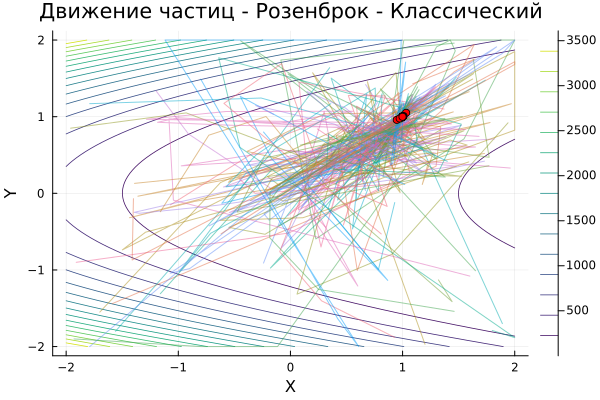

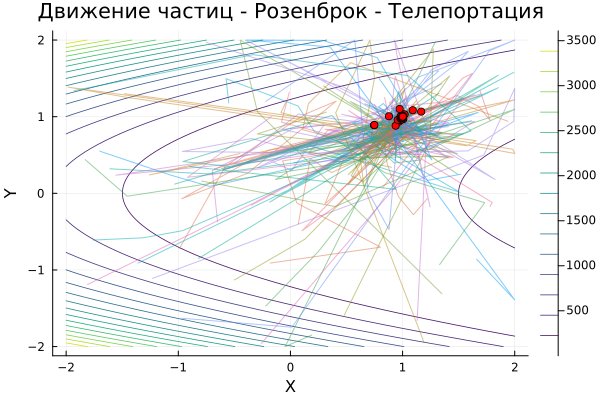

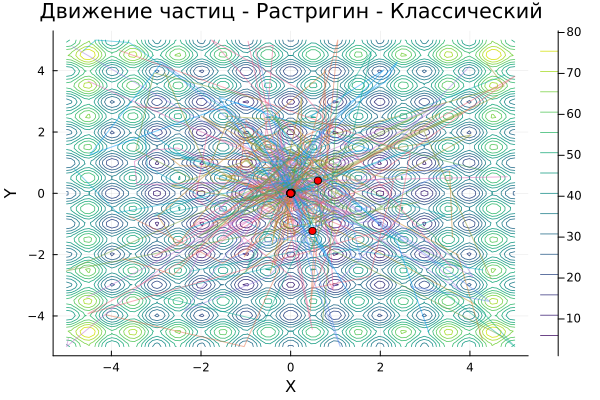

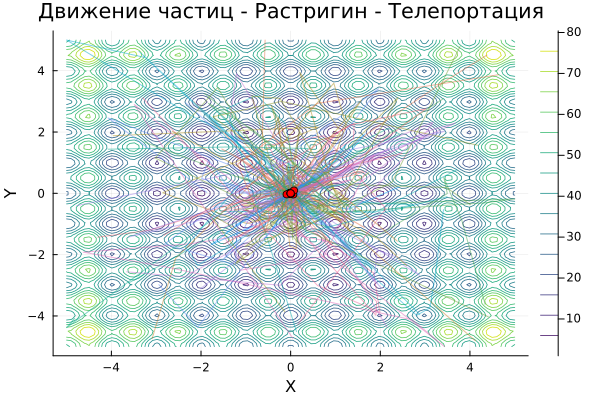

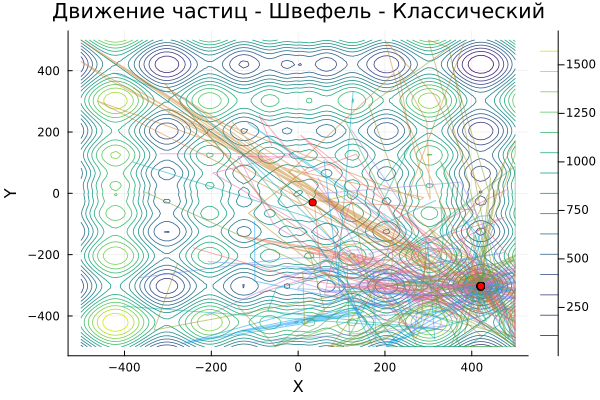

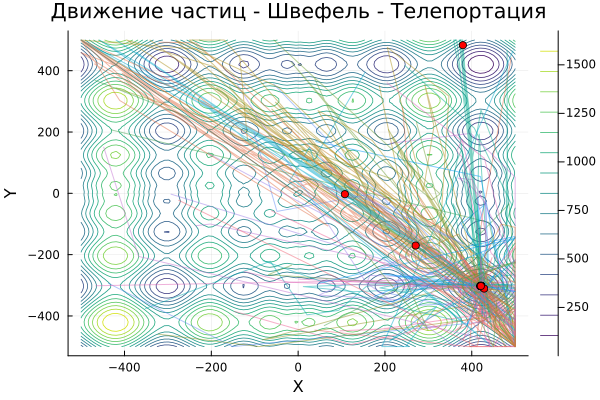

In [ ]:
using Random, Statistics, Printf, Plots

gr()

function rosenbrock(x, y)
    return (1 - x)^2 + 100 * (y - x^2)^2
end

function rastrigin(x, y)
    return 20 + x^2 + y^2 - 10 * (cos(2π * x) + cos(2π * y))
end

function schwefel(x, y)
    return 418.9829 * 2 - (x * sin(sqrt(abs(x))) + y * sin(sqrt(abs(y))))
end

function initialize_particles(num_particles, bounds)
    particles = [[rand(bounds[1]:0.01:bounds[2]), rand(bounds[1]:0.01:bounds[2])] for _ in 1:num_particles]
    velocities = [[rand(bounds[1]:0.01:bounds[2]), rand(bounds[1]:0.01:bounds[2])] for _ in 1:num_particles]
    return particles, velocities
end

function particle_swarm_optimization(num_particles, bounds, w, c1, c2, max_iters, objective_function; teleport=false)
    particles, velocities = initialize_particles(num_particles, bounds)
    personal_best = deepcopy(particles)
    personal_best_values = [objective_function(p[1], p[2]) for p in particles]

    global_best_index = argmin(personal_best_values)
    global_best = personal_best[global_best_index]
    global_best_value = personal_best_values[global_best_index]

    history = Vector{Vector{Vector{Float64}}}()
    push!(history, deepcopy(particles))

    iter_count = 0
    start_time = time()
    prev_best_value = global_best_value
    no_change_iters = 0
    tolerance = 1e-6

    for iter in 1:max_iters
        iter_count += 1

        for i in 1:num_particles
            velocities[i] .= w .* velocities[i] .+
                             c1 .* rand() .* (personal_best[i] .- particles[i]) .+
                             c2 .* rand() .* (global_best .- particles[i])

            particles[i] .= particles[i] .+ velocities[i]
            particles[i] .= clamp.(particles[i], bounds[1], bounds[2])

            value = objective_function(particles[i][1], particles[i][2])
            if value < personal_best_values[i]
                personal_best[i] = copy(particles[i])
                personal_best_values[i] = value
            end

            if value < global_best_value
                global_best = copy(particles[i])
                global_best_value = value
            end
        end

        push!(history, deepcopy(particles))

        if teleport && iter % 10 == 0
            for i in 1:num_particles
                if rand() < 0.2
                    particles[i] .= global_best + 0.1 * randn(2)
                end
            end
        end

        if abs(prev_best_value - global_best_value) < tolerance
            no_change_iters += 1
        else
            no_change_iters = 0
        end
        prev_best_value = global_best_value

        if no_change_iters >= 10
            println("Остановлено досрочно на $iter итерации")
            break
        end
    end

    exec_time = time() - start_time

    return global_best, global_best_value, history, iter_count, exec_time
end

function plot_particles(history, bounds, name, objective_function)
    x_range = range(bounds[1], bounds[2], length=100)
    y_range = range(bounds[1], bounds[2], length=100)
    Z = [objective_function(x, y) for x in x_range, y in y_range]

    p = contour(x_range, y_range, Z, linewidth=0.8, title="Движение частиц - $name",
                xlabel="X", ylabel="Y", color=:viridis)

    num_particles = length(history[1])

    for i in 1:num_particles
        x_vals = [history[t][i][1] for t in 1:length(history)]
        y_vals = [history[t][i][2] for t in 1:length(history)]
        plot!(p, x_vals, y_vals, lw=1, legend=false, alpha=0.5)
    end

    scatter!(p, [history[end][i][1] for i in 1:num_particles],
                [history[end][i][2] for i in 1:num_particles],
                color=:red, label="Финальные точки", marker=:circle)

    display(p)
end

function run_experiments(objective_function, bounds, name)
    println("\n===== Исследование для $name =====")

    for num_particles in [10, 50, 100]
        best_point, best_value, history, iter_count, exec_time = particle_swarm_optimization(
            num_particles, bounds, 0.5, 1.5, 1.5, 10000, objective_function
        )
        @printf("Частиц: %d | Время: %.5f сек | Итерации: %d | Минимум: %.5f | Точка: (%.5f, %.5f)\n",
                num_particles, exec_time, iter_count, best_value, best_point[1], best_point[2])
    end

    for c2 in [0.5, 1.5, 2.5]
        best_point, best_value, history, iter_count, exec_time = particle_swarm_optimization(
            50, bounds, 0.5, 1.5, c2, 10000, objective_function
        )
        @printf("c2: %.1f | Время: %.5f сек | Итерации: %d | Минимум: %.5f | Точка: (%.5f, %.5f)\n",
                c2, exec_time, iter_count, best_value, best_point[1], best_point[2])
    end

    best_classic, val_classic, hist_classic, iter_classic, time_classic = particle_swarm_optimization(
        50, bounds, 0.5, 1.5, 1.5, 10000, objective_function
    )

    best_teleport, val_teleport, hist_teleport, iter_teleport, time_teleport = particle_swarm_optimization(
        50, bounds, 0.5, 1.5, 1.5, 10000, objective_function; teleport=true
    )

    @printf("Классический: Время: %.5f сек | Итерации: %d | Минимум: %.5f | Точка: (%.5f, %.5f)\n",
            time_classic, iter_classic, val_classic, best_classic[1], best_classic[2])
    @printf("Телепортация: Время: %.5f сек | Итерации: %d | Минимум: %.5f | Точка: (%.5f, %.5f)\n",
            time_teleport, iter_teleport, val_teleport, best_teleport[1], best_teleport[2])

    plot_particles(hist_classic, bounds, "$name - Классический", objective_function)
    plot_particles(hist_teleport, bounds, "$name - Телепортация", objective_function)
end

run_experiments(rosenbrock, (-2.0, 2.0), "Розенброк")
run_experiments(rastrigin, (-5.0, 5.0), "Растригин")
run_experiments(schwefel, (-500.0, 500.0), "Швефель")